# Air analysis in Madrid

## Download the datasets

In [1]:
import requests
import zipfile
import os
import shutil
import pandas as pd

In [2]:
# URLs
year_url = {
    2024: 'https://datos.madrid.es/egob/catalogo/201200-10306320-calidad-aire-horario.zip',
    2023: 'https://datos.madrid.es/egob/catalogo/201200-10306319-calidad-aire-horario.zip',
    2022: 'https://datos.madrid.es/egob/catalogo/201200-10306318-calidad-aire-horario.zip',
    2021: 'https://datos.madrid.es/egob/catalogo/201200-10306317-calidad-aire-horario.zip',
    2020: 'https://datos.madrid.es/egob/catalogo/201200-10306316-calidad-aire-horario.zip',
    2019: 'https://datos.madrid.es/egob/catalogo/201200-42-calidad-aire-horario.zip',
    2018: 'https://datos.madrid.es/egob/catalogo/201200-10306314-calidad-aire-horario.zip',
    2017: 'https://datos.madrid.es/egob/catalogo/201200-10306313-calidad-aire-horario.zip',
    2016: 'https://datos.madrid.es/egob/catalogo/201200-28-calidad-aire-horario.zip',
    2015: 'https://datos.madrid.es/egob/catalogo/201200-27-calidad-aire-horario.zip',
    2014: 'https://datos.madrid.es/egob/catalogo/201200-26-calidad-aire-horario.zip',
    2013: 'https://datos.madrid.es/egob/catalogo/201200-23-calidad-aire-horario.zip',
    2012: 'https://datos.madrid.es/egob/catalogo/201200-22-calidad-aire-horario.zip',
    2011: 'https://datos.madrid.es/egob/catalogo/201200-21-calidad-aire-horario.zip',
    2010: 'https://datos.madrid.es/egob/catalogo/201200-20-calidad-aire-horario.zip',
    2009: 'https://datos.madrid.es/egob/catalogo/201200-19-calidad-aire-horario.zip',
    2008: 'https://datos.madrid.es/egob/catalogo/201200-18-calidad-aire-horario.zip',
    2007: 'https://datos.madrid.es/egob/catalogo/201200-17-calidad-aire-horario.zip',
    2006: 'https://datos.madrid.es/egob/catalogo/201200-16-calidad-aire-horario.zip',
    2005: "https://datos.madrid.es/egob/catalogo/201200-15-calidad-aire-horario.zip",
    2004: "https://datos.madrid.es/egob/catalogo/201200-14-calidad-aire-horario.zip",
    2003: "https://datos.madrid.es/egob/catalogo/201200-13-calidad-aire-horario.zip",
    2002: "https://datos.madrid.es/egob/catalogo/201200-30-calidad-aire-horario.zip",
    2001: "https://datos.madrid.es/egob/catalogo/201200-29-calidad-aire-horario.zip"
}

In [3]:
output_dir = "calidad_aire_madrid"
os.makedirs(output_dir, exist_ok=True)

In [4]:
# Function to delete all contents of a folder
def delete_folder(folder, verbose = 0):
    if verbose > 0: print(f"Deleting {folder} content ")
    for f in os.listdir(folder):
        f_path = os.path.join(folder, f)
        try:
            if verbose > 1: print(f"Delete {f_path}?")
            if os.path.isfile(f_path) or os.path.islink(f_path):
                if verbose > 1: print("Yes")
                os.unlink(f_path)
            elif os.path.isdir(f_path):
                if verbose > 1: print(f"It is a folder! Recursive delet {f_path}")
                delete_folder(f_path)
        except Exception as e:
            print(f'Error deleting {f_path}: {e}')

# Function to delete only .txt files in a folder
def delete_folder_txt_xml(folder, verbose = 0):
    if verbose > 0: print(f"Deleting {folder} content (txt, xml)")
    for f in os.listdir(folder):
        f_path = os.path.join(folder, f)
        try:
            if verbose > 1: print(f"Delete {f_path}?")
            if (os.path.isfile(f_path) or os.path.islink(f_path)) and ( f_path.endswith('.txt') or f_path.endswith('.xml')):
                if verbose > 1: print("Yes")
                os.unlink(f_path)
            elif os.path.isdir(f_path):
                if verbose > 1: print(f"It is a folder! Recursive delet {f_path}")
                delete_folder_txt_xml(f_path, verbose)
            elif verbose > 1: print("No")
        except Exception as e:
            print(f'Error deleting {f_path}: {e}')

In [5]:
def move_contents(src_dir, dst_dir):
    for item in os.listdir(src_dir):
        s = os.path.join(src_dir, item)
        d = os.path.join(dst_dir, item)
        if os.path.isdir(s):
            shutil.move(s, d)
        else:
            shutil.move(s, dst_dir)
            
def download_and_get_name(url, output_dir, year, verbose=0):
    if verbose > 0: print(f"Downloading from {url} to {output_dir}")
    
    # Crear una carpeta específica para el año
    year_dir = os.path.join(output_dir, f"Anio{year-2000}")
    
    # Vaciar la carpeta de destino
    if os.path.exists(year_dir):
        delete_folder(year_dir)
    os.makedirs(year_dir, exist_ok=True)
    
    # Descargar el archivo
    response = requests.get(url)
    if response.status_code == 200:
        if verbose > 1: print(f"Saving response into a zip")
        zip_file_path = os.path.join(year_dir, "temp_download.zip")
        with open(zip_file_path, "wb") as file:
            file.write(response.content)
        if verbose > 1: print(f"Extracting zip")
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(year_dir)
        if verbose > 1: print(f"Removing temporary zip")
        os.remove(zip_file_path)

        # Mover el contenido de la subcarpeta AnioX a year_dir si existe
        subdirs = [d for d in os.listdir(year_dir) if os.path.isdir(os.path.join(year_dir, d))]
        for subdir in subdirs:
            if subdir.startswith('Anio'):
                move_contents(os.path.join(year_dir, subdir), year_dir)
                shutil.rmtree(os.path.join(year_dir, subdir))
        
        f = year_dir
        if verbose > 0: print(f"Downloaded {f}")
    else:
        print(f"No Downloaded file: {response.status_code}")
    if verbose > 0: print("Deleting txt and xml")
    delete_folder_txt_xml(year_dir, verbose)
    if verbose > 0: print("Download finished")
    return f

In [6]:
foo_2024 = 'https://datos.madrid.es/egob/catalogo/201200-10306320-calidad-aire-horario.zip'  # URL de ejemplo
foo_2021 = "https://datos.madrid.es/egob/catalogo/201200-10306317-calidad-aire-horario.zip" 
foo_2010 = "https://datos.madrid.es/egob/catalogo/201200-20-calidad-aire-horario.zip"
foo_dir = "calidad_aire_madrid"  # Directorio de destino
foo = download_and_get_name(foo_2024, foo_dir, 2024, verbose = 1)
print(f"Archivo descargado: {foo}")

Downloaded calidad_aire_madrid/Anio24
Deleting txt and xml
Deleting calidad_aire_madrid/Anio24 content (txt, xml)
Download finished
Archivo descargado: calidad_aire_madrid/Anio24


In [7]:
all_data = pd.DataFrame()
data_path = 'calidad_aire_madrid'
delete_folder(data_path)
for year, url in year_url.items():
    print(f"Downloading {year} data from {url}")
    download_and_get_name(url, data_path, year, verbose = 1)
    try:
        for root, dirs, files in os.walk(data_path):
            print(f"{data_path} - {root} | {dirs} | {files}")
            for file in files:
                print(f"{file}")
                if file.endswith('.csv'):
                    print(f"Add {file} to data")
                    file_path = os.path.join(root, file)
                    yearly_data = pd.read_csv(file_path, sep=';')
                    all_data = pd.concat([all_data, yearly_data], ignore_index=True)
            print(f"Delete {data_path}")
        else:
            print(f"Response error for {year}: {response.status_code}")
    except Exception as e:
        print(f"Could not download {year}. Output_dir: {output_dir}")

# Guardar el DataFrame concatenado en un solo archivo CSV
all_data.to_csv("calidad_aire_madrid_2001_2024.csv", index=False)

Downloaded calidad_aire_madrid/Anio24
Deleting txt and xml
Deleting calidad_aire_madrid/Anio24 content (txt, xml)
Download finished
calidad_aire_madrid - calidad_aire_madrid | ['Anio5', 'Anio3', 'Anio15', 'Anio24', 'Anio18', 'Anio13', 'Anio9', 'Anio6', 'Anio22', 'Anio11', '.ipynb_checkpoints', 'Anio12', 'Anio17', 'Anio20', 'Anio16', 'Anio10', 'Anio2', 'Anio4', 'Anio8', 'Anio7', 'Anio19', 'Anio21', 'Anio1', 'Anio14', 'Anio23'] | []
Delete calidad_aire_madrid
calidad_aire_madrid - calidad_aire_madrid/Anio5 | [] | []
Delete calidad_aire_madrid
calidad_aire_madrid - calidad_aire_madrid/Anio3 | [] | []
Delete calidad_aire_madrid
calidad_aire_madrid - calidad_aire_madrid/Anio15 | [] | []
Delete calidad_aire_madrid
calidad_aire_madrid - calidad_aire_madrid/Anio24 | [] | ['feb_mo24.csv', 'may_mo24.csv', 'abr_mo24.csv', 'mar_mo24.csv', 'jun_mo24.csv', 'ene_mo24.csv']
feb_mo24.csv
Add feb_mo24.csv to data
may_mo24.csv
Add may_mo24.csv to data
abr_mo24.csv
Add abr_mo24.csv to data
mar_mo24.csv
Ad

In [8]:
print(all_data.shape)
all_data.head()

(14117970, 56)


,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,4,1,28079004_1_38,2024,2,1,1.0,V,...,6.0,V,6.0,V,4.0,V,4.0,V,3.0,V
1,28,79,4,1,28079004_1_38,2024,2,2,3.0,V,...,4.0,V,5.0,V,3.0,V,2.0,V,2.0,V
2,28,79,4,1,28079004_1_38,2024,2,3,1.0,V,...,3.0,V,4.0,V,3.0,V,2.0,V,2.0,V
3,28,79,4,1,28079004_1_38,2024,2,4,1.0,V,...,2.0,V,3.0,V,6.0,V,3.0,V,2.0,V
4,28,79,4,1,28079004_1_38,2024,2,5,1.0,V,...,5.0,V,4.0,V,4.0,V,5.0,V,4.0,V


In [9]:
22*24*365

192720

In [10]:
set(all_data['ANO'])

{2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021,
 2022,
 2023,
 2024}

In [11]:
all_data.to_csv("calidad_aire_madrid_2001_2024.csv", index=False, sep  = ";")

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from IPython.display import display

ETL

In [13]:
filename = 'calidad_aire_madrid_2001_2024'
filetype = '.csv'
filepath = './'+filename+filetype
filepath_processed = os.path.expanduser('~/data/'+'horario_ensanche_vallecas'+filetype)
df = pd.read_csv(filepath, sep = ";")

In [14]:
df.columns

Index(['PROVINCIA', 'MUNICIPIO', 'ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO',
       'ANO', 'MES', 'DIA', 'H01', 'V01', 'H02', 'V02', 'H03', 'V03', 'H04',
       'V04', 'H05', 'V05', 'H06', 'V06', 'H07', 'V07', 'H08', 'V08', 'H09',
       'V09', 'H10', 'V10', 'H11', 'V11', 'H12', 'V12', 'H13', 'V13', 'H14',
       'V14', 'H15', 'V15', 'H16', 'V16', 'H17', 'V17', 'H18', 'V18', 'H19',
       'V19', 'H20', 'V20', 'H21', 'V21', 'H22', 'V22', 'H23', 'V23', 'H24',
       'V24'],
      dtype='object')

In [15]:
display(df.head())

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,H20,V20,H21,V21,H22,V22,H23,V23,H24,V24
0,28,79,4,1,28079004_1_38,2024,2,1,1.0,V,...,6.0,V,6.0,V,4.0,V,4.0,V,3.0,V
1,28,79,4,1,28079004_1_38,2024,2,2,3.0,V,...,4.0,V,5.0,V,3.0,V,2.0,V,2.0,V
2,28,79,4,1,28079004_1_38,2024,2,3,1.0,V,...,3.0,V,4.0,V,3.0,V,2.0,V,2.0,V
3,28,79,4,1,28079004_1_38,2024,2,4,1.0,V,...,2.0,V,3.0,V,6.0,V,3.0,V,2.0,V
4,28,79,4,1,28079004_1_38,2024,2,5,1.0,V,...,5.0,V,4.0,V,4.0,V,5.0,V,4.0,V


## Organize data and set timestamp

In [16]:
df_reorganized = pd.DataFrame()
for hour in range(1, 25):
    hour_str = f'H{hour:02d}'
    validation_str = f'V{hour:02d}'
    df_hour = df[['ANO', 'MES', 'DIA', 'ESTACION', 'MAGNITUD', hour_str, validation_str]].copy()
    df_hour.columns = ['year', 'month', 'day', 'station', 'magnitude', 'value', 'validation']
    df_hour['hour'] = int(hour)
    df_reorganized = pd.concat([df_reorganized, df_hour])
display(df_reorganized.head())

,year,month,day,station,magnitude,value,validation,hour
0,2024,2,1,4,1,1.0,V,1
1,2024,2,2,4,1,3.0,V,1
2,2024,2,3,4,1,1.0,V,1
3,2024,2,4,4,1,1.0,V,1
4,2024,2,5,4,1,1.0,V,1


In [17]:
df_reorganized['timestamp'] = pd.to_datetime(df_reorganized[['year', 'month', 'day', 'hour']])

In [18]:
df_reorganized.set_index('timestamp', inplace=True)

In [19]:
df_reorganized.drop(columns=['year', 'month', 'day', 'hour', 'validation'], inplace=True)

In [20]:
display(df_reorganized.head())

,station,magnitude,value
timestamp,,,
2024-02-01 01:00:00,4,1,1.0
2024-02-02 01:00:00,4,1,3.0
2024-02-03 01:00:00,4,1,1.0
2024-02-04 01:00:00,4,1,1.0
2024-02-05 01:00:00,4,1,1.0


## Select Ensanche de Vallecas

In [21]:
df_ensanche = df_reorganized[df_reorganized['station'] == 58].copy()
df_ensanche.drop(columns = ['station'], inplace = True)
display(df_ensanche.head())

,magnitude,value
timestamp,,
2024-02-01 01:00:00,7,4.0
2024-02-02 01:00:00,7,2.0
2024-02-03 01:00:00,7,3.0
2024-02-04 01:00:00,7,2.0
2024-02-05 01:00:00,7,2.0


### Filter magnitudes
(in this case, all available magnituded are selected)

In [22]:
magnitudes = [7, 8, 12, 14]
df_ensanche_filtered = df_ensanche[df_ensanche['magnitude'].isin(magnitudes)]
#display(df_ensanche_filtered.head())
df_ensanche_pivot = df_ensanche_filtered.pivot_table(index='timestamp', columns='magnitude', values='value')
df_ensanche_pivot.columns = ['NO', 'NO2', 'NOx', 'O3']
display(df_ensanche_pivot.head())

,NO,NO2,NOx,O3
timestamp,,,,
2009-11-30 01:00:00,0.0,0.0,0.0,0.0
2009-11-30 02:00:00,0.0,0.0,0.0,0.0
2009-11-30 03:00:00,0.0,0.0,0.0,0.0
2009-11-30 04:00:00,0.0,0.0,0.0,0.0
2009-11-30 05:00:00,0.0,0.0,0.0,0.0


### Save as CSV

In [23]:
print(filepath_processed)
df_ensanche_pivot.to_csv(filepath_processed)

/home/macu/data/horario_ensanche_vallecas.csv


## Analysis

### Load the data

In [24]:
# Leer los datos preparados
df = pd.read_csv(filepath_processed, index_col='timestamp', parse_dates=True)

In [25]:
df.head()
df.shape

(127800, 4)

### Select a magnitude for the analysis

In [34]:
magnitudes = df.columns
print(magnitudes)

Index(['NO', 'NO2', 'NOx', 'O3'], dtype='object')


In [35]:
magnitude = 'NO'
ts = df[magnitude]

### Decompose the time series to check seasonality

In [36]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

#### Daily patterns

In [37]:
decomposition = seasonal_decompose(ts, model='additive', period=24)

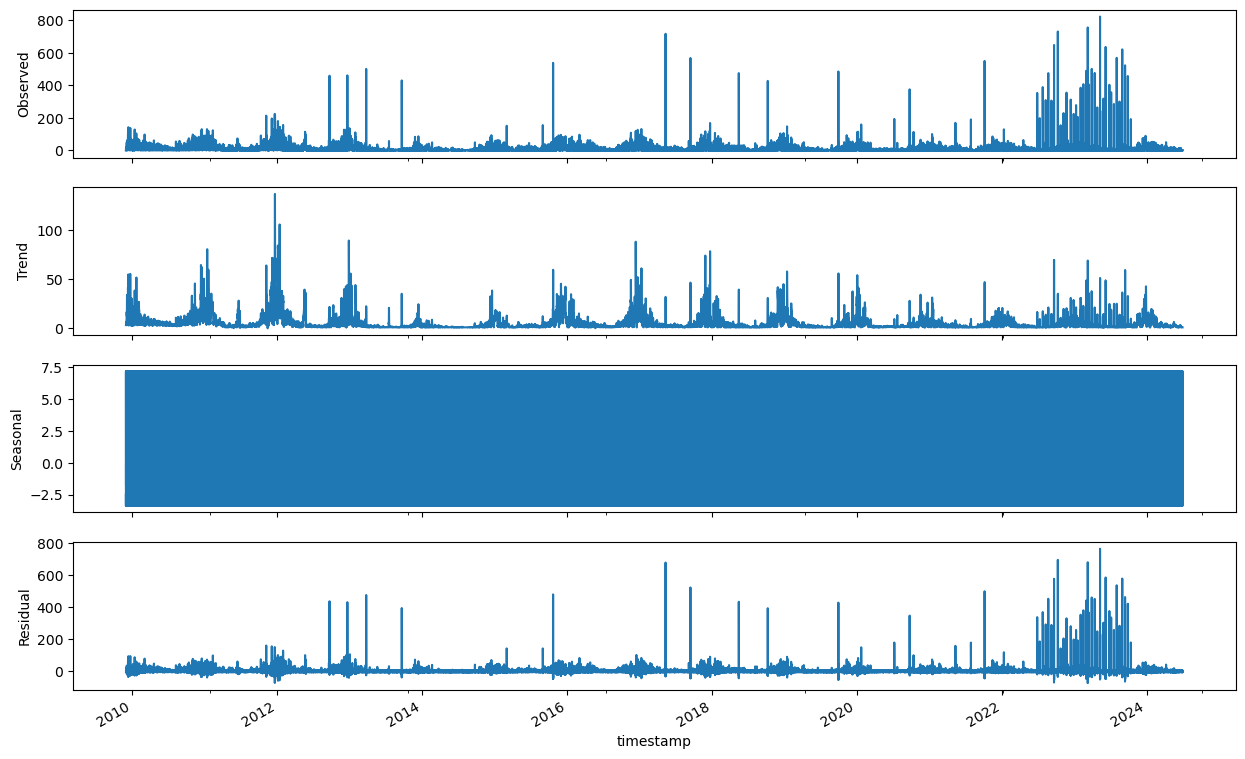

In [38]:
fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

#### Weekly patterns

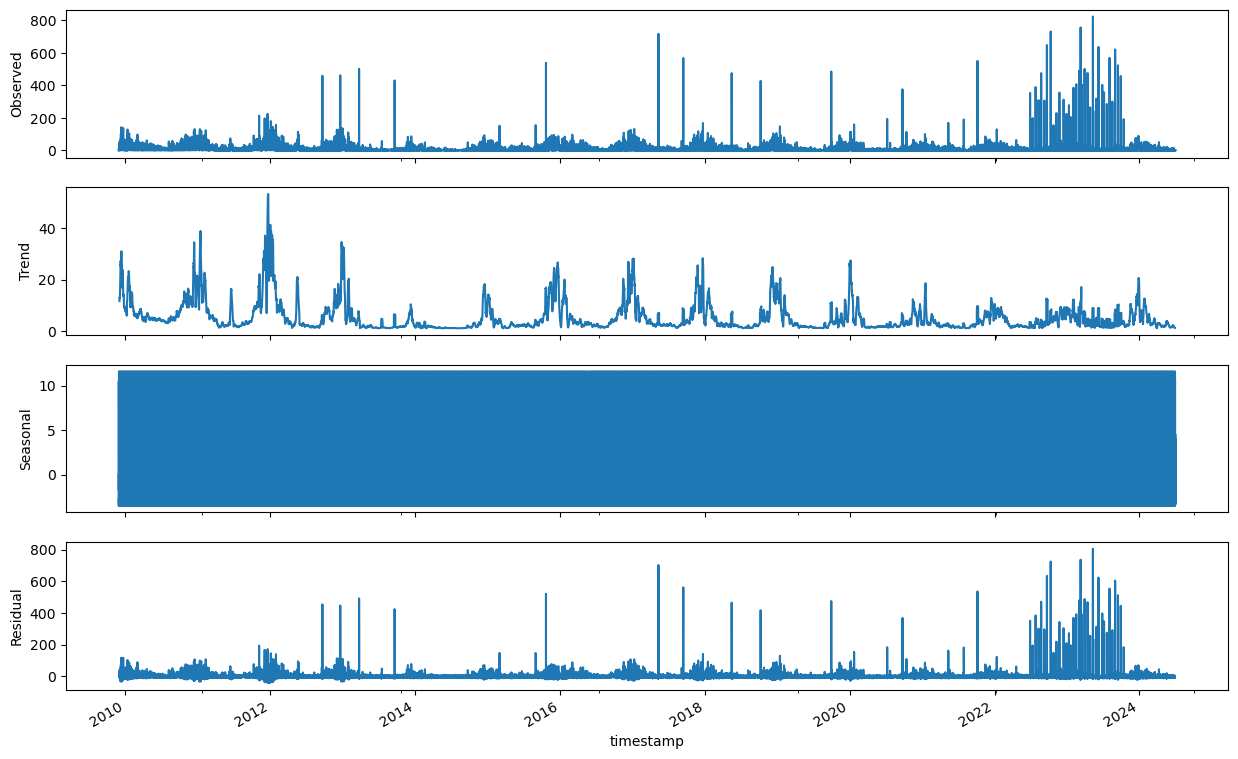

In [39]:
decomposition = seasonal_decompose(ts, model='additive', period=168)
fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

#### Monthly patterns

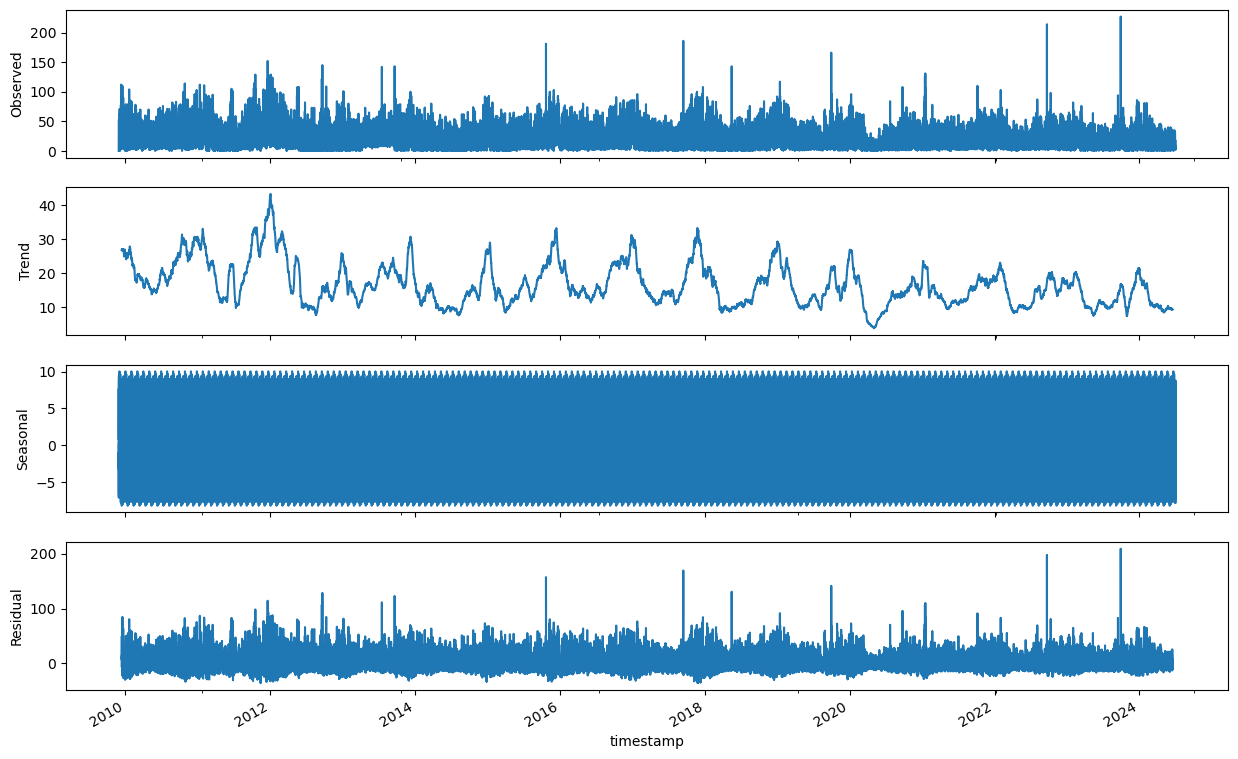

In [31]:
decomposition = seasonal_decompose(ts, model='additive', period=720)
fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)
decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

#### Zooming

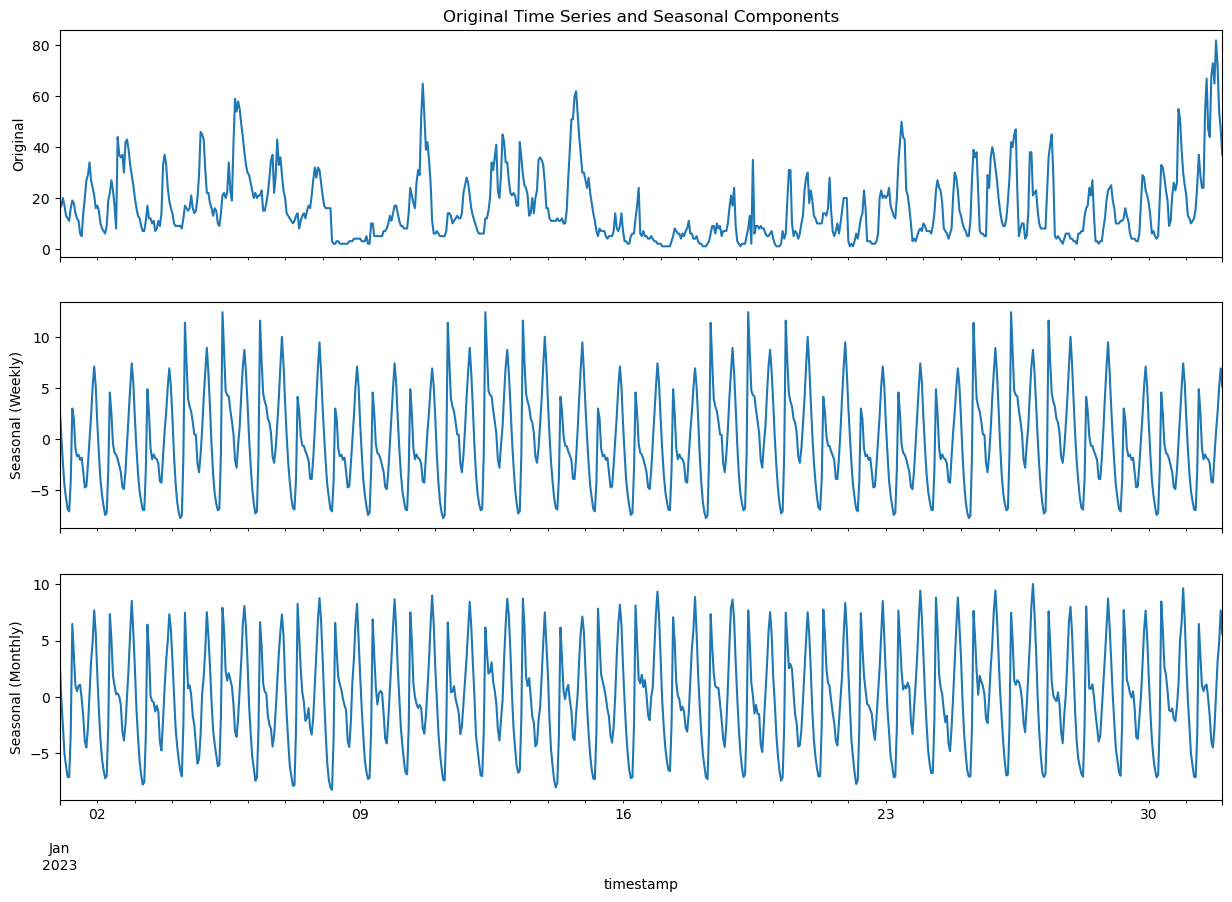

In [32]:
# Descomponer la serie temporal para verificar la estacionalidad semanal y mensual
decomposition_weekly = seasonal_decompose(ts, model='additive', period=168)
decomposition_monthly = seasonal_decompose(ts, model='additive', period=720)

# Definir el rango para hacer zoom (por ejemplo, un mes específico)
start_date = '2023-01-01'
end_date = '2023-01-31'

# Filtrar la serie temporal original y las componentes estacionales para el rango especificado
ts_zoom = ts[start_date:end_date]
seasonal_weekly_zoom = decomposition_weekly.seasonal[start_date:end_date]
seasonal_monthly_zoom = decomposition_monthly.seasonal[start_date:end_date]

# Graficar la serie temporal original y las componentes estacionales con zoom
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

# Serie temporal original
ts_zoom.plot(ax=axes[0])
axes[0].set_ylabel('Original')
axes[0].set_title('Original Time Series and Seasonal Components')

# Componente estacional semanal
seasonal_weekly_zoom.plot(ax=axes[1])
axes[1].set_ylabel('Seasonal (Weekly)')

# Componente estacional mensual
seasonal_monthly_zoom.plot(ax=axes[2])
axes[2].set_ylabel('Seasonal (Monthly)')

plt.show()